In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import soundfile
import os
import yt_dlp

from pydub import AudioSegment

import librosa
from IPython.display import Audio, display


#ignore warnings
import warnings
warnings.filterwarnings("ignore")


import sys
sys.path.append("..")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [3]:
import os
import yt_dlp
from pydub import AudioSegment
import librosa
from IPython.display import Audio, display

def download_and_crop_audio(url, temp_name, crop_name, audio_dir, start_ms, end_ms):
    os.makedirs(audio_dir, exist_ok=True)
    mp3_path = os.path.join(audio_dir, temp_name + ".mp3")
    wav_path = os.path.join(audio_dir, crop_name)

    if not os.path.exists(wav_path):
        print("Downloading and cropping audio...")
        ydl_opts = {
            'format': 'bestaudio/best',
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
            }],
            'outtmpl': os.path.join(audio_dir, temp_name + '.%(ext)s'),
        }

        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])

        AudioSegment.from_mp3(mp3_path)[start_ms:end_ms].export(wav_path, format="wav")
        os.remove(mp3_path)
        print("Saved cropped audio:", wav_path)
    else:
        print("Cropped audio already exists.")

    signal, sr = librosa.load(wav_path, sr=None)
    display(Audio(signal, rate=sr))


In [4]:

audio_dir = "audio"  # Directory to save audio files
if not os.path.exists(audio_dir):
    os.makedirs(audio_dir)

# URL and filenames for the first audio
# url = "https://www.youtube.com/watch?v=ApXoWvfEYVU" # Sunflower by Post Malone
url = "https://www.youtube.com/watch?v=4JZ-o3iAJv4" # Oppenheimer by The Hamiltones

download_and_crop_audio(
    url=url,
    temp_name="downloaded",
    crop_name="clip.wav",
    audio_dir="audio",
    start_ms=2000,
    end_ms=7000
)


Cropped audio already exists.


In [5]:
def load_audio_librosa(file_path):
    audio_signal, sample_rate = librosa.load(file_path, sr=None)  # sr=None ensures original sampling rate is used
    print(f"Audio loaded successfully.")
    print(f"Signal shape: {audio_signal.shape} Sample rate: {sample_rate} Hz Audio duration:{len(audio_signal) / sample_rate} seconds")
    return audio_signal, sample_rate

def play_audio(file_path):
    display(Audio(file_path, autoplay=True))

def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    ax = plt.gca()
    plt.plot(np.arange(len(audio)) / sr, audio, color=clr, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    # format_axes(ax)
    plt.show()

def audio_freq_plot(audio, sr, tl):
    plt.figure(figsize=(15, 4))
    ax = plt.gca()
    plt.magnitude_spectrum(audio, Fs=sr, color="blue")
    plt.title(tl)
    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

Audio loaded successfully.
Signal shape: (220500,) Sample rate: 44100 Hz Audio duration:5.0 seconds
Audio Signal: [-0.01898193 -0.01564026 -0.01390076 ...  0.02363586  0.02372742
  0.0177002 ]


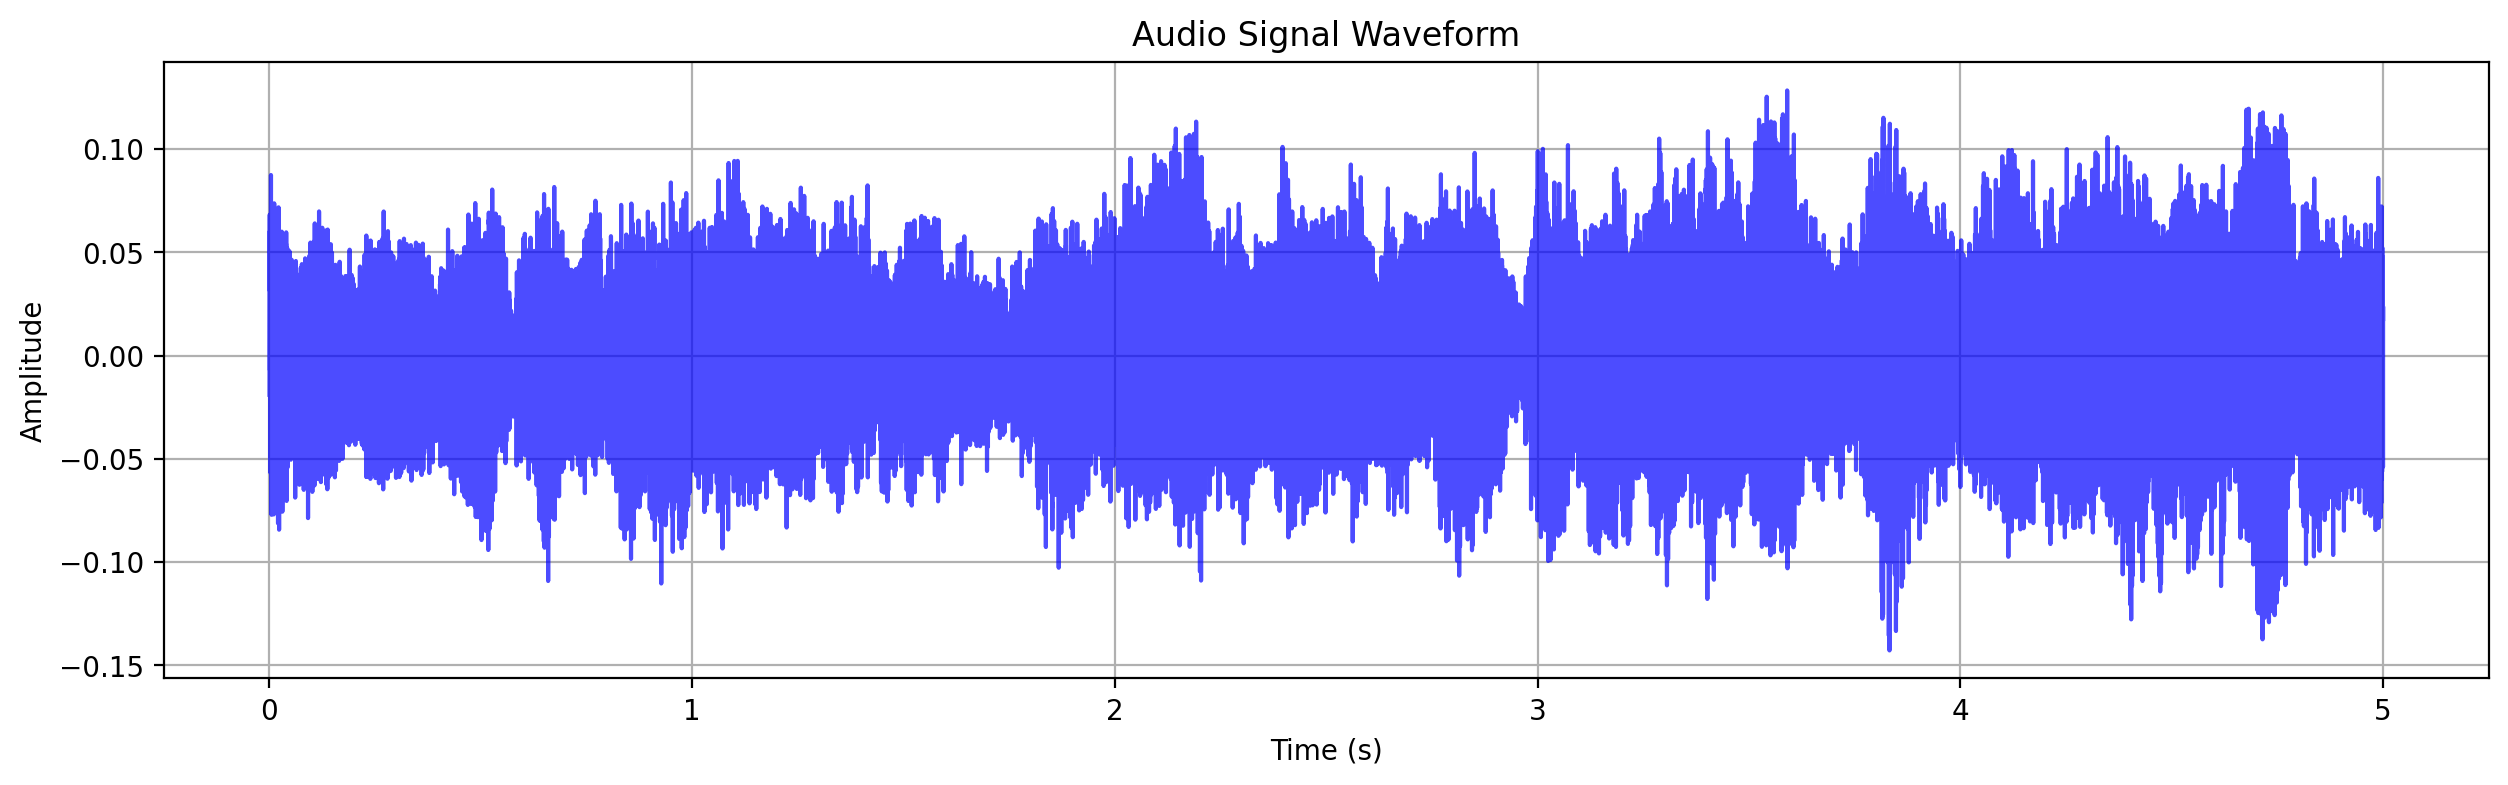

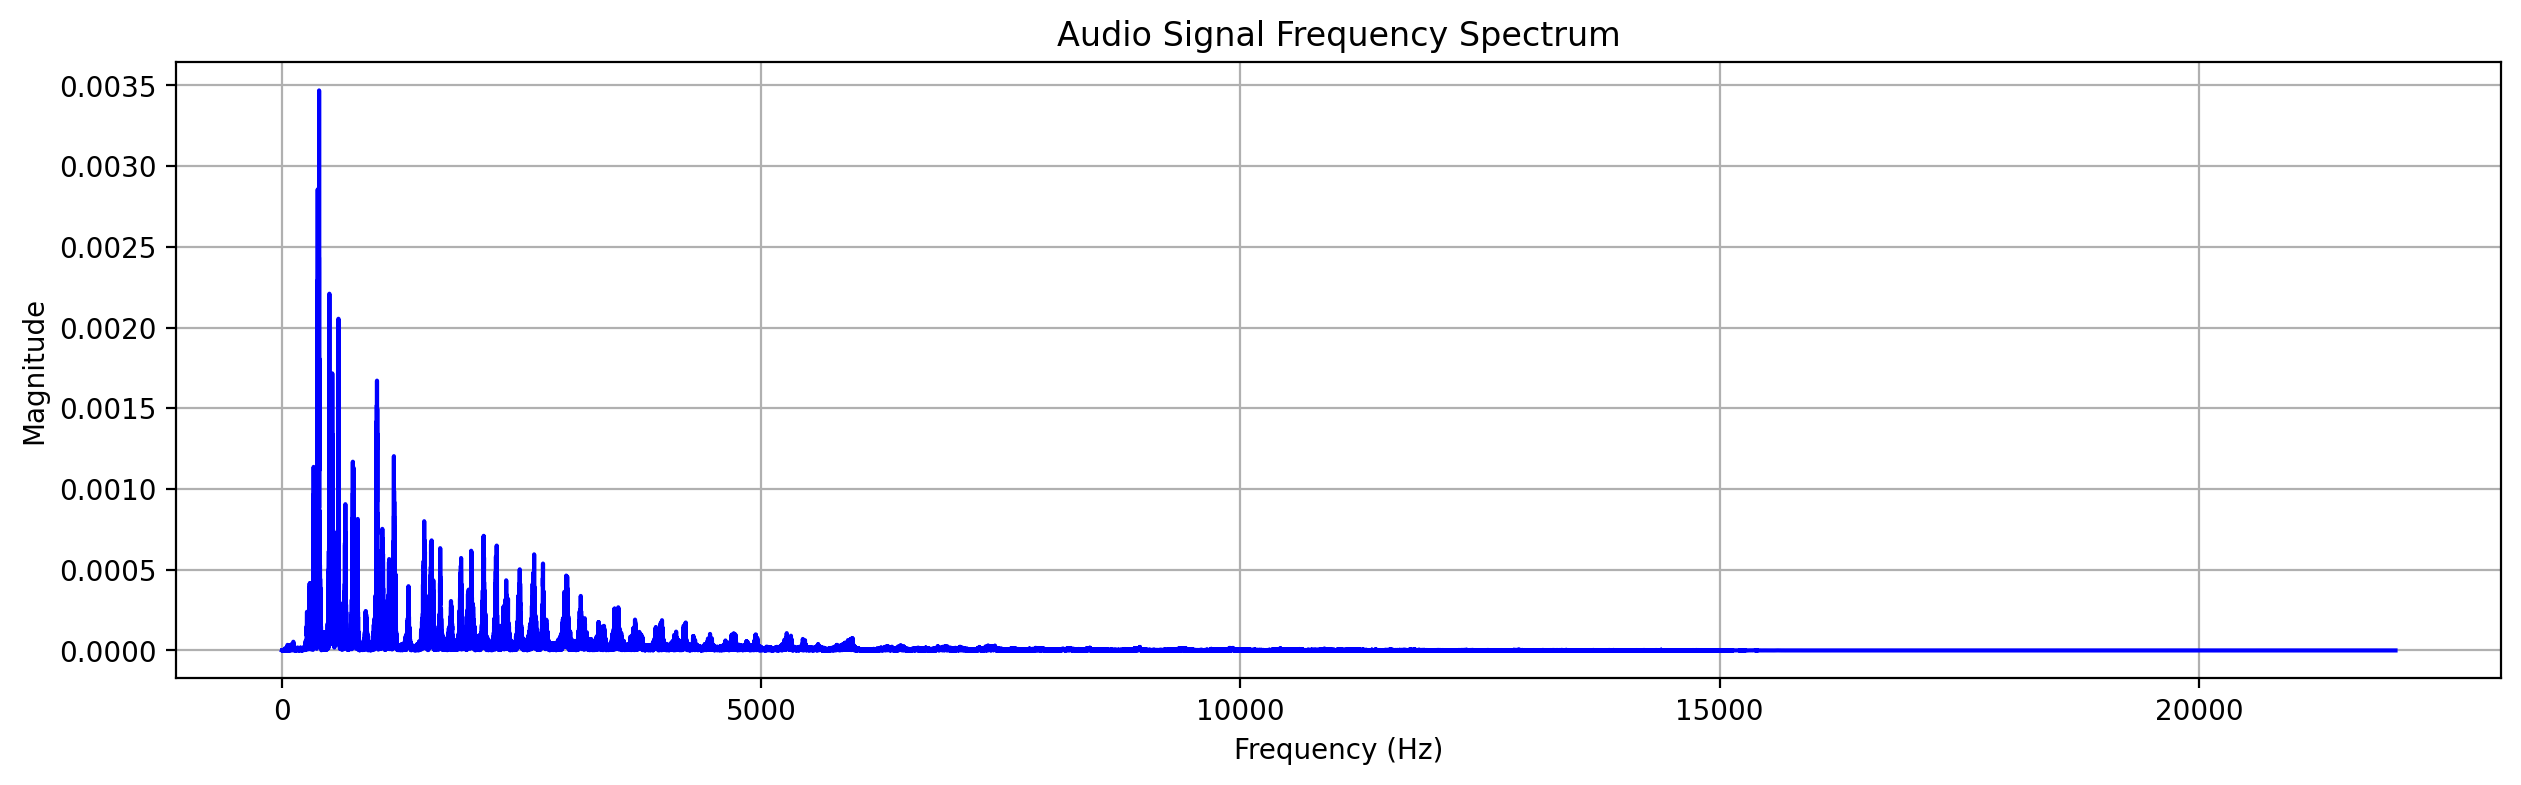

In [6]:
file_path = os.path.join(audio_dir, "clip.wav")
audio_signal, sample_rate = load_audio_librosa(file_path)
print("Audio Signal:", audio_signal)  

play_audio(file_path)
audio_plot(audio_signal, sample_rate, "blue", "Audio Signal Waveform")
audio_freq_plot(audio_signal, sample_rate, "Audio Signal Frequency Spectrum")

In [7]:
def create_time_series(audio):
    X = torch.arange(0, len(audio)).unsqueeze(1).float()
    X = X / X.max() * 200 - 100
    print(X.shape)
    print(X)
    return X

X = create_time_series(audio_signal)



torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [8]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from scipy import sparse
import numpy as np
from sklearn.linear_model import LinearRegression

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [9]:
class TorchLinearRegression(nn.Module):
    def __init__(self, X):
        super().__init__()
        self.linear = nn.Linear(X, 1)

    def forward(self, x):
        return self.linear(x)

In [10]:
num_features = 16000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

X_rff = X_rff.to(device)
audio_signal = torch.tensor(audio_signal, dtype=torch.float32).to(device)



# Model on GPU
model = TorchLinearRegression(X_rff.shape[1]).to(device)


y = audio_signal.unsqueeze(1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    pred = model(X_rff)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")



torch.Size([220500, 16000])
tensor([[ 0.0056,  0.0060,  0.0109,  ...,  0.0107, -0.0022,  0.0099],
        [ 0.0048,  0.0052,  0.0109,  ...,  0.0108, -0.0026,  0.0103],
        [ 0.0040,  0.0044,  0.0109,  ...,  0.0108, -0.0029,  0.0106],
        ...,
        [-0.0064, -0.0016,  0.0087,  ...,  0.0112,  0.0101, -0.0095],
        [-0.0056, -0.0026,  0.0087,  ...,  0.0111,  0.0102, -0.0090],
        [-0.0048, -0.0035,  0.0087,  ...,  0.0111,  0.0104, -0.0085]])
Epoch 0, Loss: 0.001029
Epoch 100, Loss: 0.000334
Epoch 200, Loss: 0.000318
Epoch 300, Loss: 0.000310
Epoch 400, Loss: 0.000306
Epoch 500, Loss: 0.000303
Epoch 600, Loss: 0.000301
Epoch 700, Loss: 0.000299
Epoch 800, Loss: 0.000298
Epoch 900, Loss: 0.000297


In [14]:
pred_audio = model(X_rff).squeeze().detach().cpu().numpy()
soundfile.write("/kaggle/working/audio/pred_audio.wav", pred_audio, sample_rate)


In [12]:
import joblib
if not os.path.exists("/kaggle/working/audio/models"):
    os.makedirs("/kaggle/working/audio/models")

joblib.dump(model, "/kaggle/working/audio/models/model_audio.pkl")

print("Model saved successfully.")

Model saved successfully.


In [17]:
print("Playing the predicted audio...")
# play_audio(f"/kaggle/working/audio/clip.wav") # Original Audio
play_audio(f"/kaggle/working/audio/pred_audio.wav") # Predicted Audio

Playing the predicted audio...


In [19]:
def calculate_error(original_audio, predicted_audio):
    original_audio = torch.tensor(original_audio, dtype=torch.float32).to(device)
    predicted_audio = torch.tensor(predicted_audio, dtype=torch.float32).to(device)

    l2_error = torch.norm(original_audio - predicted_audio).item()
    l1_error = torch.sum(torch.abs(original_audio - predicted_audio)).item()

    return l2_error, l1_error


# Calculate the errors for the first audio signal
l2_error, l1_error = calculate_error(audio_signal, pred_audio)
print("L2 error for audio 1:", l2_error)
print("L1 error for audio 1:", l1_error)

L2 error for audio 1: 8.072164535522461
L1 error for audio 1: 2982.833740234375


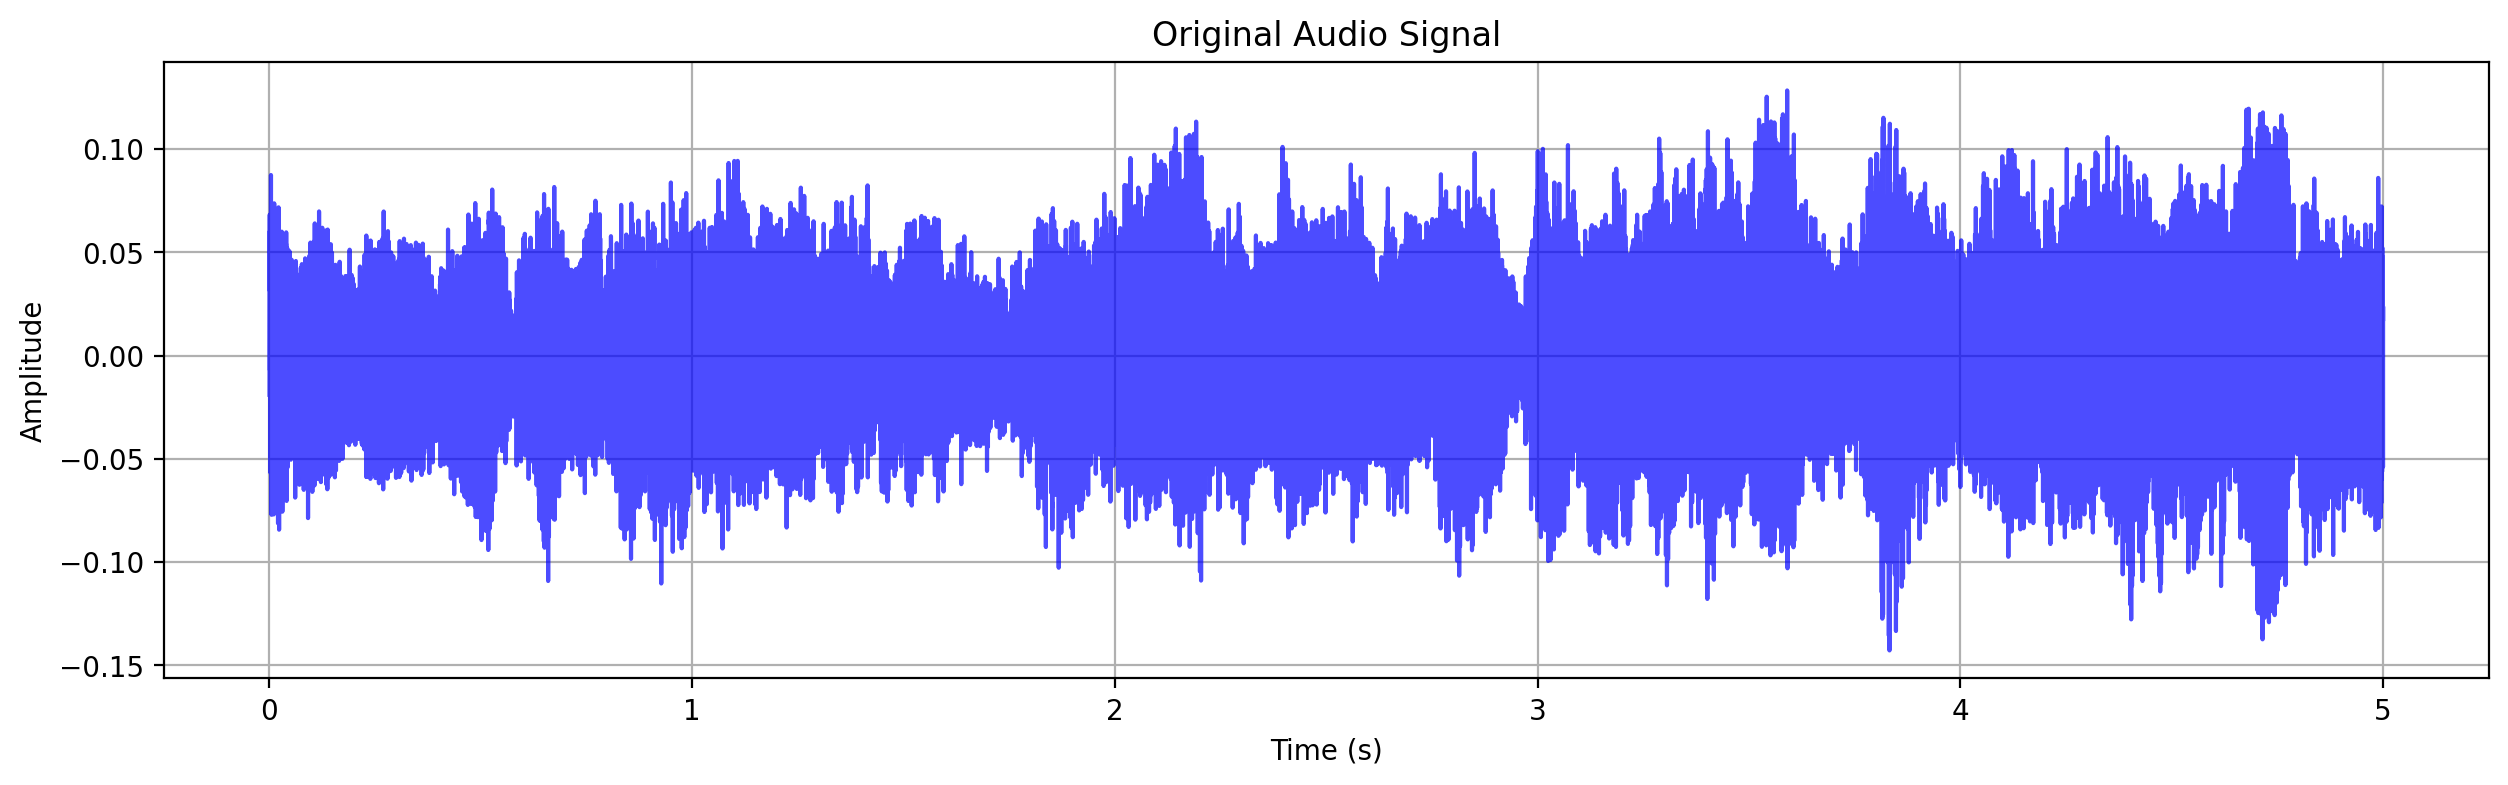

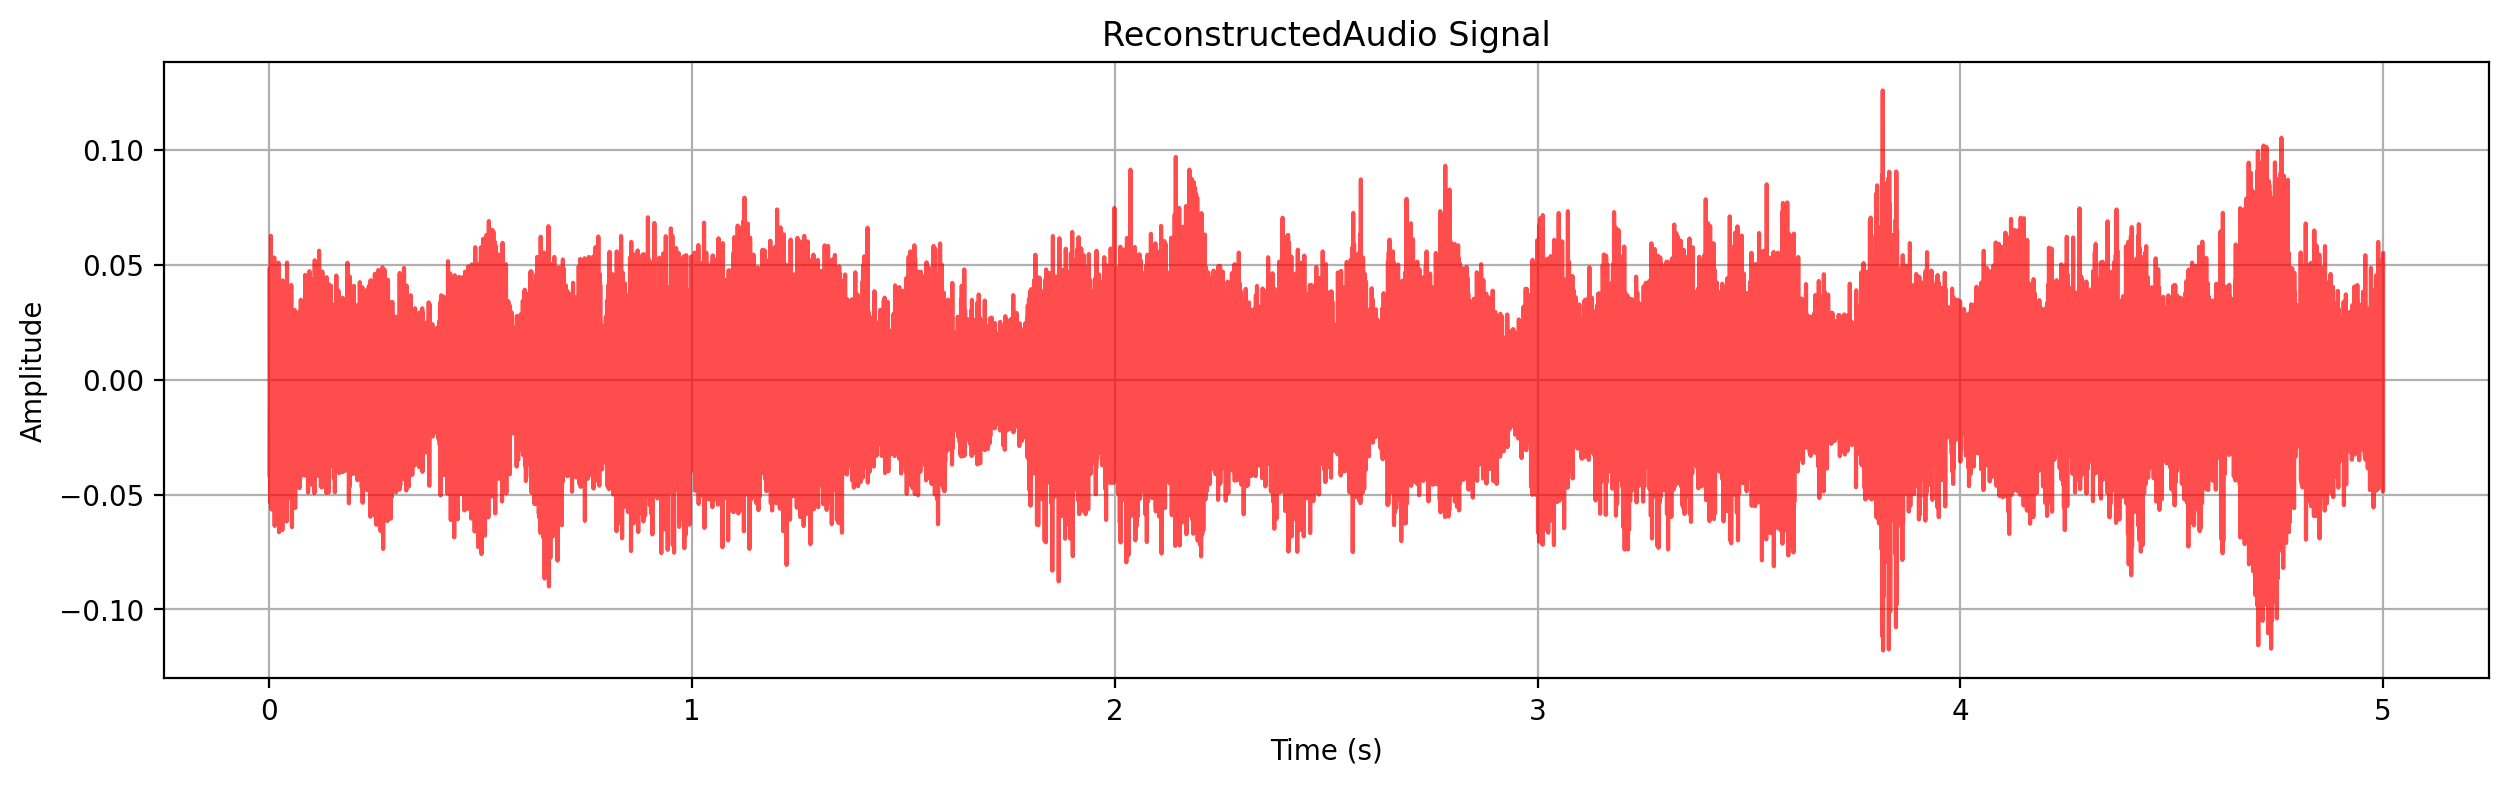

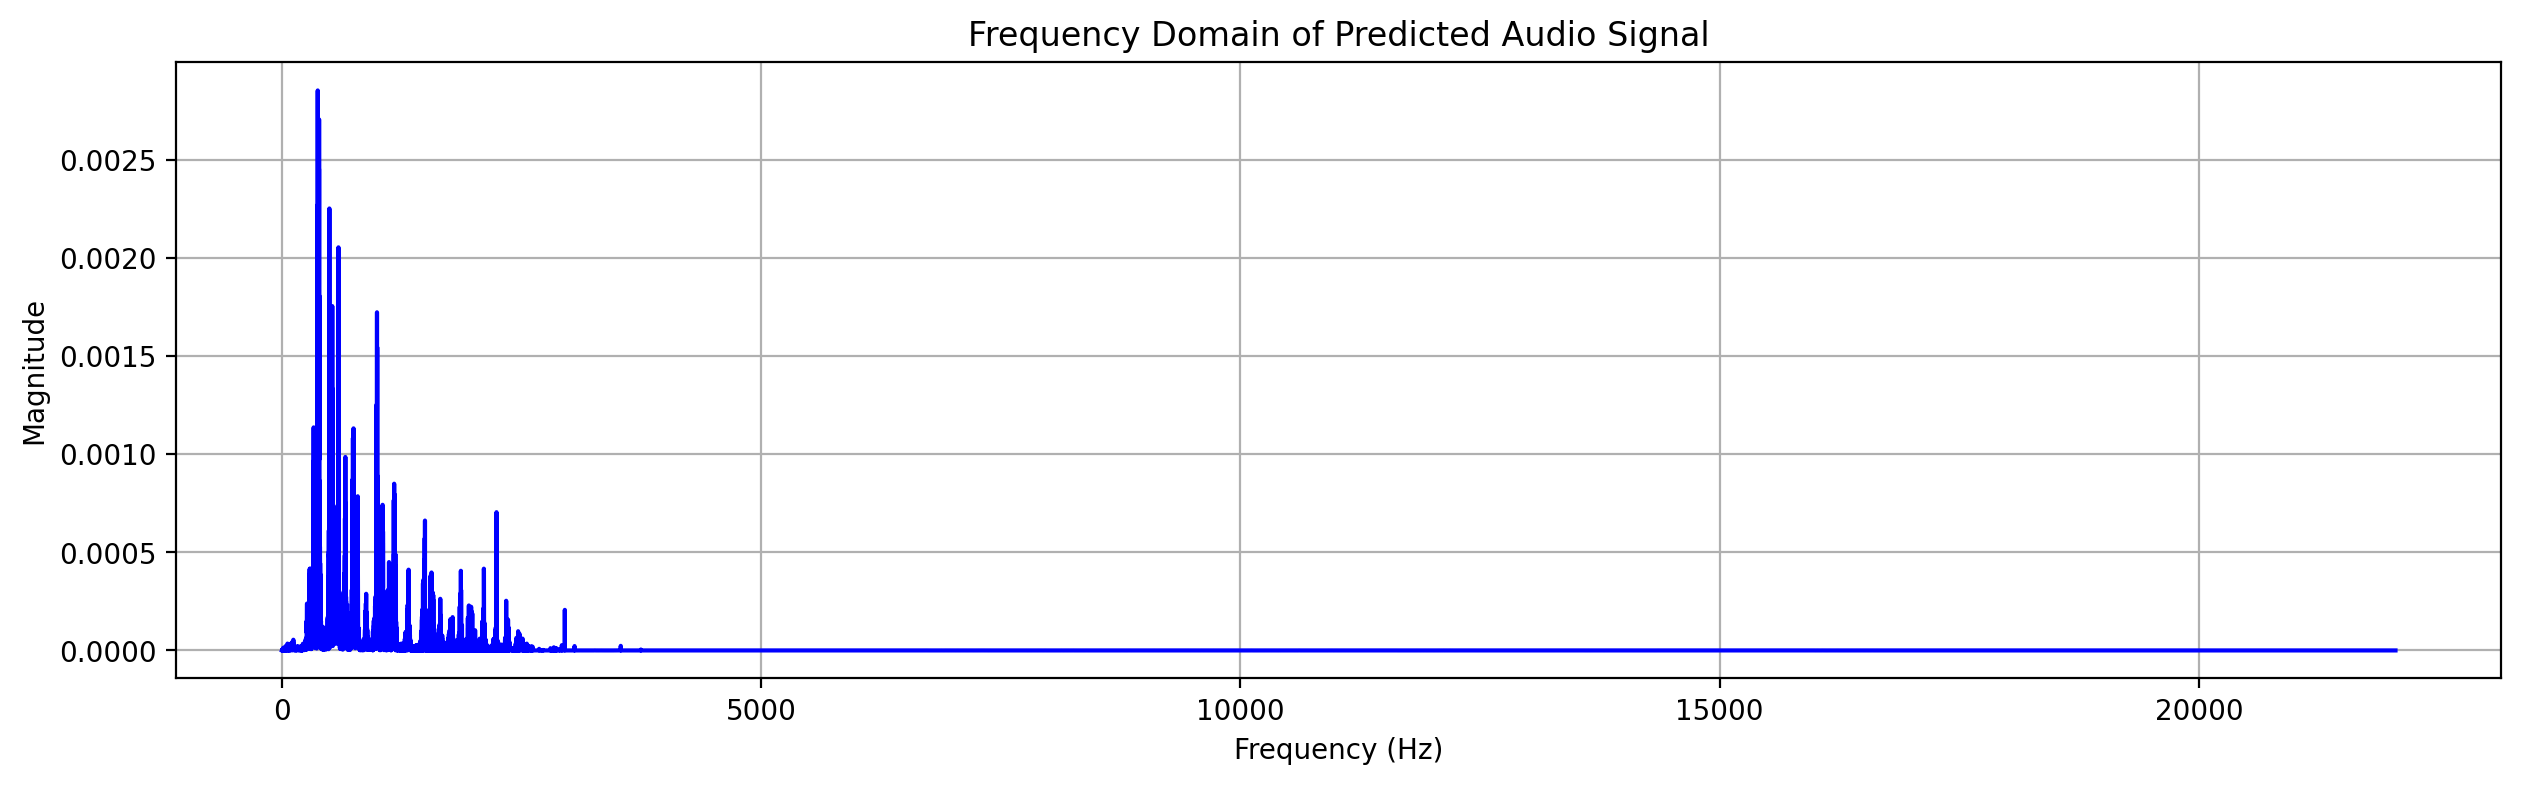

In [27]:
# audio_signal = audio_signal.detach().cpu().numpy()
# pred_audio = pred_audio.detach().cpu().numpy()

audio_plot(audio_signal, sample_rate, 'blue', 'Original Audio Signal')  # Original audio signal
audio_plot(pred_audio, sample_rate, 'red', 'ReconstructedAudio Signal')  # Predicted audio signal
audio_freq_plot(pred_audio, sample_rate, 'Frequency Domain of Predicted Audio Signal') 

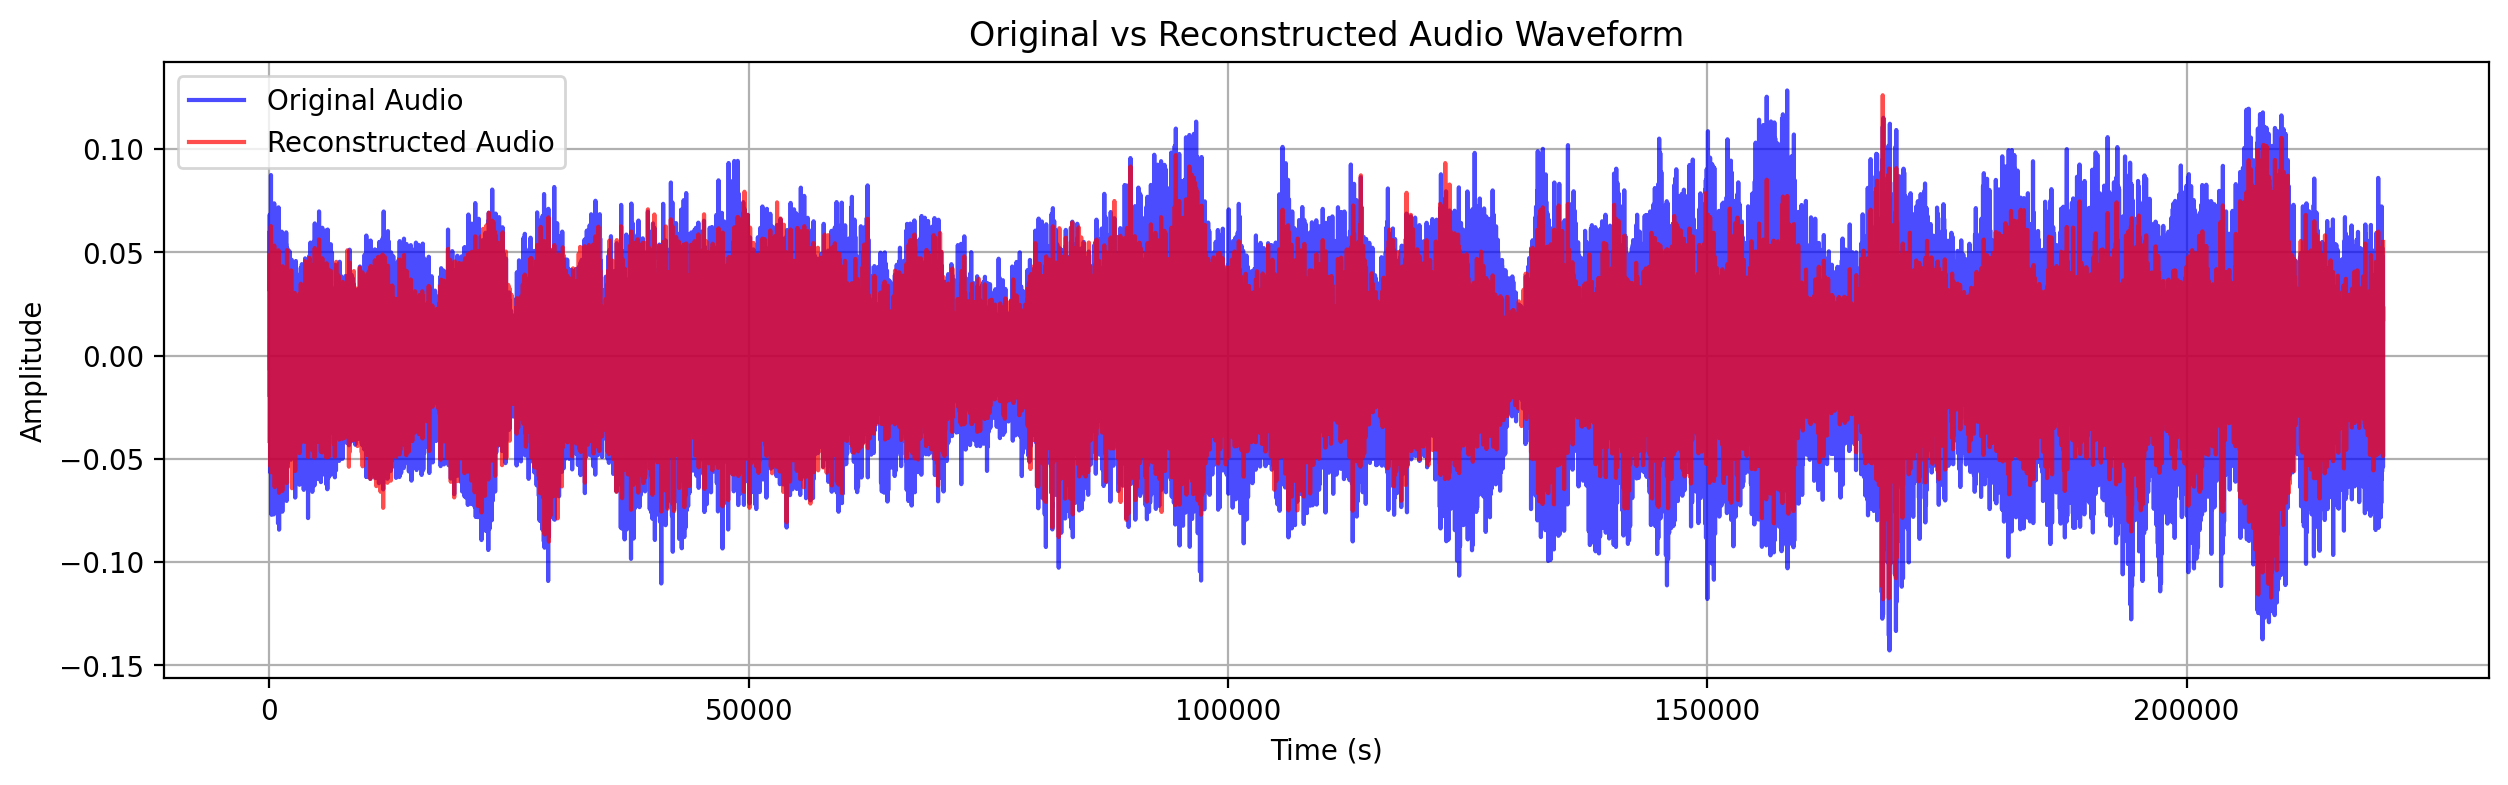

In [25]:

def plot_compare(audio, pred_audio):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color='blue', alpha=0.7, label='Original Audio')
    plt.plot(pred_audio, color='red', alpha=0.7, label='Reconstructed Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Original vs Reconstructed Audio Waveform')
    plt.grid()
    plt.legend()
    plt.show()

plot_compare(audio_signal, pred_audio)

In [26]:
def calculate_rmse(original, reconstructed):
    
    original = np.array(original)
    reconstructed = np.array(reconstructed)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((original - reconstructed) ** 2))
    return rmse

def calculate_snr(original, reconstructed):
    original = np.array(original)
    reconstructed = np.array(reconstructed)

    # Calculate SNR
    noise = original - reconstructed
    snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
    return snr

# Calculate RMSE
rmse_value = calculate_rmse(audio_signal, pred_audio)
print(f"RMSE: {rmse_value}")

# Calculate SNR
snr_value = calculate_snr(audio_signal, pred_audio)
print(f"SNR: {snr_value} dB")

RMSE: 0.017190389335155487
SNR: 5.308058261871338 dB
